In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Data Loading

In [3]:
data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

# Exploratory Data Analysis

In [4]:
data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
test_data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [6]:
null_values = data.isna().sum()


null_columns = null_values[null_values > 0]
print("\nColumns with null values:")
print(null_columns)



Columns with null values:
Cross_Street           16552
Modus_Operandi          2741
Victim_Sex              2624
Victim_Descent          2624
Premise_Description        5
Weapon_Used_Code       12665
Weapon_Description     12665
dtype: int64


In [7]:
null_values = test_data.isna().sum()


null_columns = null_values[null_values > 0]
print("\nColumns with null values:")
print(null_columns)


Columns with null values:
Cross_Street           4190
Modus_Operandi          684
Victim_Sex              643
Victim_Descent          643
Premise_Description       1
Weapon_Used_Code       3153
Weapon_Description     3153
dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


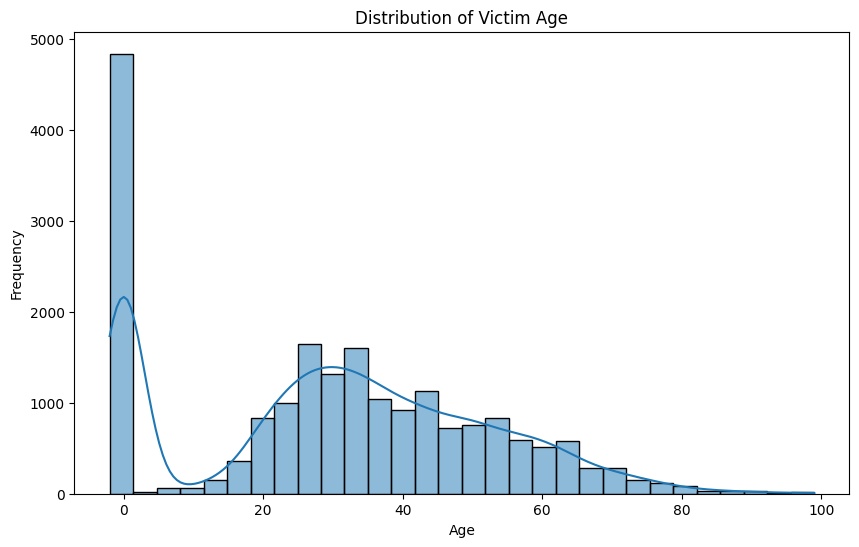

In [8]:
# Plot a histogram to visualize the distribution of victim_age
plt.figure(figsize=(10, 6))
sns.histplot(data['Victim_Age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Victim Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



Replacing Negative age values with nan

In [9]:
# sorted(data['Victim_Age'].unique())
data['Victim_Age'] = data['Victim_Age'].replace([-2, -1], np.nan)

In [10]:
# sorted(test_data['Victim_Age'].unique())
test_data['Victim_Age'] = test_data['Victim_Age'].replace([-2, -1], np.nan)

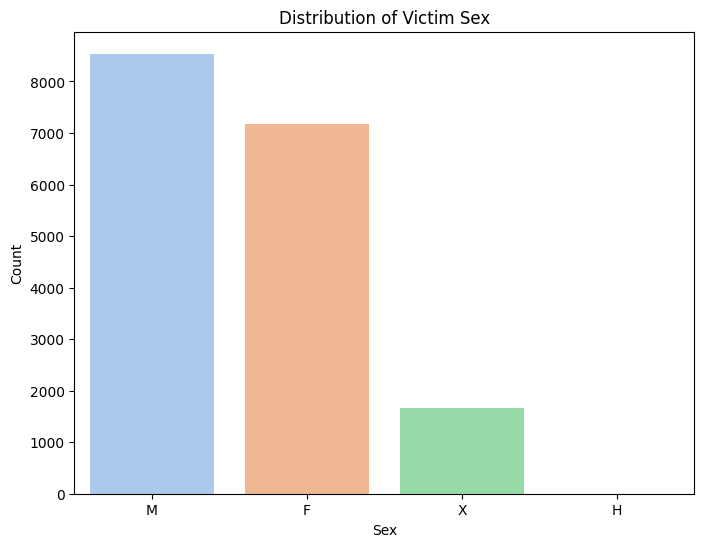

In [11]:
# Plot a countplot to visualize the distribution of Victim_Sex
plt.figure(figsize=(8, 6))
sns.countplot(x='Victim_Sex', data=data, order=data['Victim_Sex'].value_counts().index, palette='pastel')
plt.title('Distribution of Victim Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

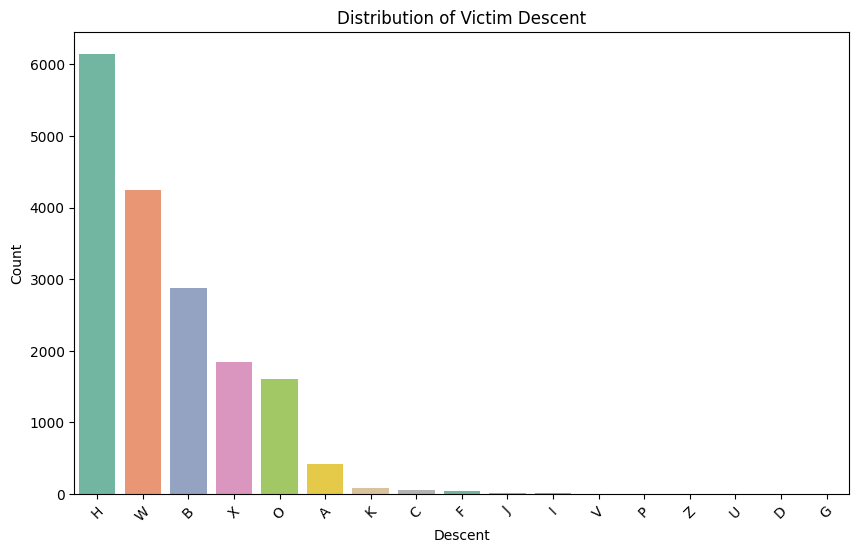

In [12]:
# Plot a countplot to visualize the distribution of Victim_Descent
plt.figure(figsize=(10, 6))
sns.countplot(x='Victim_Descent', data=data, order=data['Victim_Descent'].value_counts().index, palette='Set2')
plt.title('Distribution of Victim Descent')
plt.xlabel('Descent')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

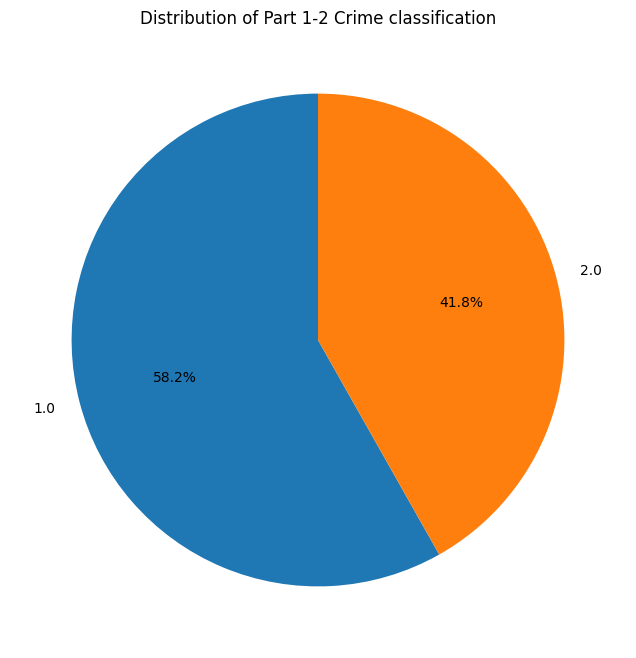

In [13]:
part_counts = data['Part 1-2'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(part_counts, labels=part_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part 1-2 Crime classification')
plt.show()

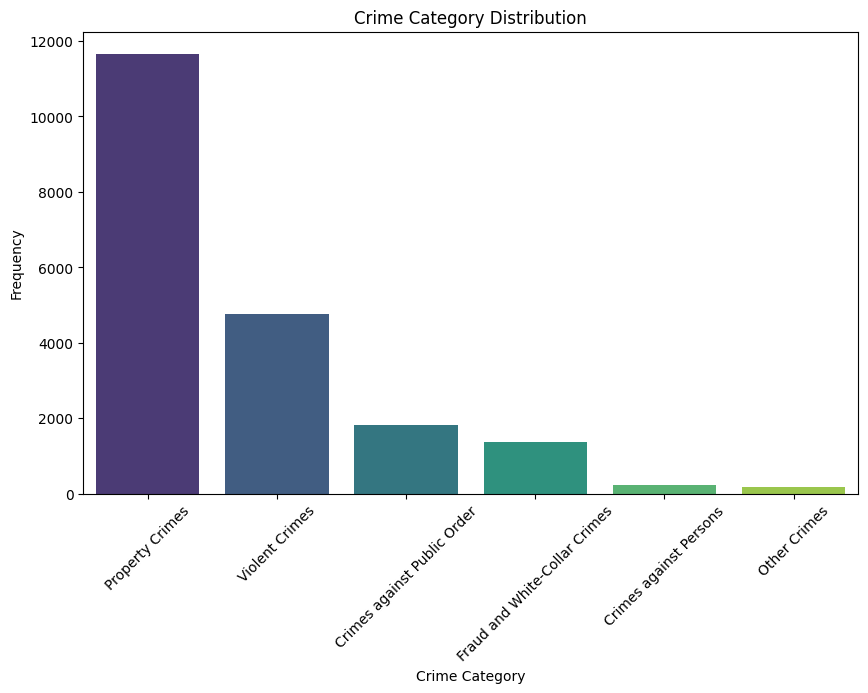

In [14]:
crime_counts = data['Crime_Category'].value_counts()
# Bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Crime_Category', order=crime_counts.index, palette='viridis')
plt.title('Crime Category Distribution')
plt.xlabel('Crime Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()




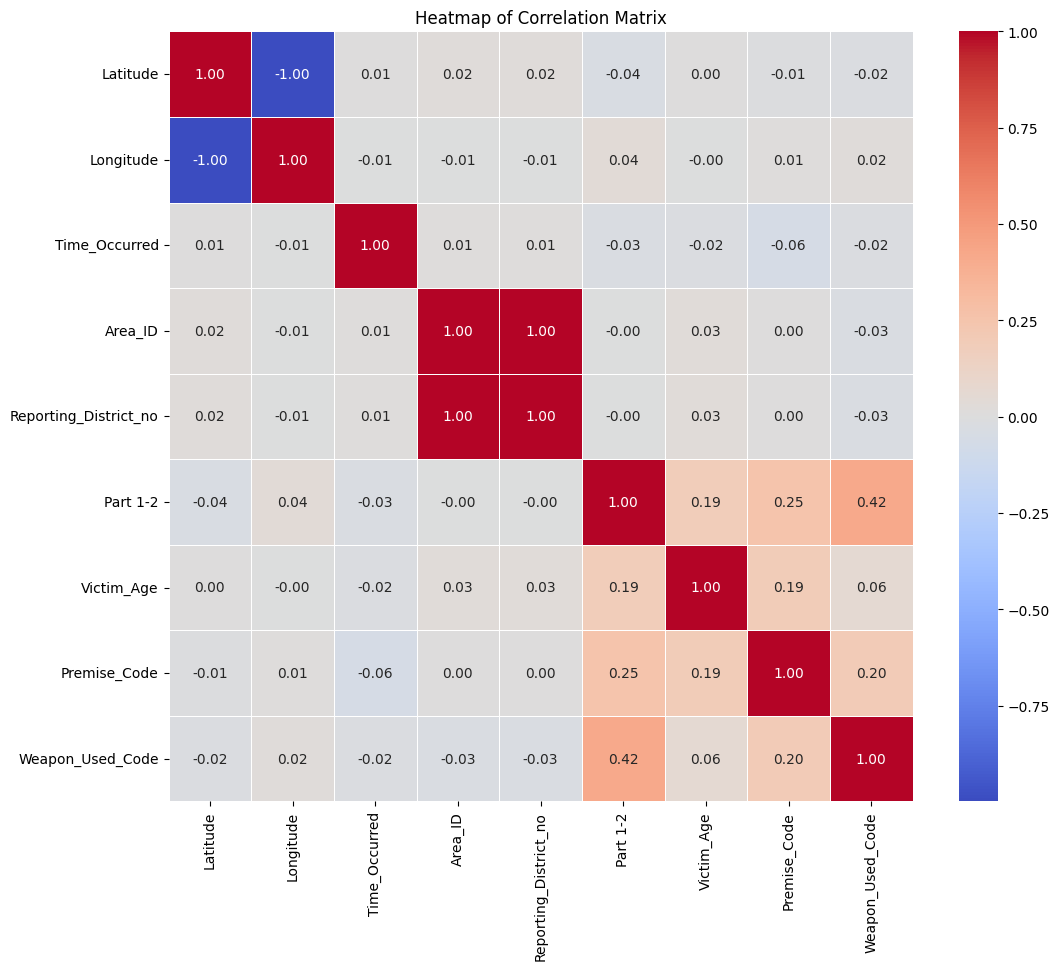

In [15]:
numerical_df = data.select_dtypes(include=['float64', 'int32'])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

# Dropping the Columns

In [16]:
#droppping Longitude and Reporting_District_no because they're correlated
#dropping Cross_street because it has nearly 80% of null values. 
#Other columns are dropped because they are redundant
new_df = data.drop(['Longitude', 'Reporting_District_no','Cross_Street','Location', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description'], axis=1)
new_test_df = test_data.drop(['Longitude', 'Reporting_District_no','Cross_Street','Location', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description'], axis=1)
new_df.shape

(20000, 14)

# Identifying feature types

In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latitude          20000 non-null  float64
 1   Date_Reported     20000 non-null  object 
 2   Date_Occurred     20000 non-null  object 
 3   Time_Occurred     20000 non-null  float64
 4   Area_ID           20000 non-null  float64
 5   Part 1-2          20000 non-null  float64
 6   Modus_Operandi    17259 non-null  object 
 7   Victim_Age        19994 non-null  float64
 8   Victim_Sex        17376 non-null  object 
 9   Victim_Descent    17376 non-null  object 
 10  Premise_Code      20000 non-null  float64
 11  Weapon_Used_Code  7335 non-null   float64
 12  Status            20000 non-null  object 
 13  Crime_Category    20000 non-null  object 
dtypes: float64(7), object(7)
memory usage: 2.1+ MB


# Feature Engineering


In [18]:
#splitting date_occurred and data_reported


new_df['Date_Occurred'] = pd.to_datetime(new_df['Date_Occurred'], format="%m/%d/%Y %I:%M:%S %p")
new_df['Day_Occured']=new_df['Date_Occurred'].dt.day
new_df['Month_Occured']=new_df['Date_Occurred'].dt.month

new_df['Date_Reported'] = pd.to_datetime(new_df['Date_Reported'], format="%m/%d/%Y %I:%M:%S %p")
new_df['Day_Reported'] = new_df['Date_Reported'].dt.day
new_df['Month_Reported'] = new_df['Date_Reported'].dt.month

new_df.head()

,Latitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Crime_Category,Day_Occured,Month_Occured,Day_Reported,Month_Reported
0,34.1522,2020-03-09,2020-03-06,1800.0,15.0,1.0,0385,75.0,M,W,101.0,NaN,IC,Property Crimes,6,3,9,3
1,34.0028,2020-02-27,2020-02-27,1345.0,13.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,400.0,IC,Property Crimes,27,2,27,2
2,34.0111,2020-08-21,2020-08-21,605.0,13.0,2.0,0329 1202,67.0,M,B,501.0,NaN,IC,Property Crimes,21,8,21,8
3,34.2953,2020-11-08,2020-11-06,1800.0,19.0,1.0,0329 1300,61.0,M,H,101.0,NaN,IC,Property Crimes,6,11,8,11
4,33.9787,2020-02-25,2020-02-25,1130.0,12.0,1.0,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,400.0,IC,Property Crimes,25,2,25,2


In [19]:
#splitting date_occurred and data_reported

new_test_df['Date_Reported'] = pd.to_datetime(new_test_df['Date_Reported'], format="%m/%d/%Y %I:%M:%S %p")
new_test_df['Day_Reported'] = new_test_df['Date_Reported'].dt.day
new_test_df['Month_Reported'] = new_test_df['Date_Reported'].dt.month


new_test_df['Date_Occurred'] = pd.to_datetime(new_test_df['Date_Occurred'], format="%m/%d/%Y %I:%M:%S %p")
new_test_df['Day_Occured'] = new_test_df['Date_Occurred'].dt.day
new_test_df['Month_Occured'] = new_test_df['Date_Occurred'].dt.month

new_test_df.head()

,Latitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Day_Reported,Month_Reported,Day_Occured,Month_Occured
0,34.0128,2020-03-03,2020-03-03,2000.0,3.0,2.0,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,400.0,IC,3,3,3,3
1,34.0726,2020-06-01,2020-04-25,1700.0,20.0,1.0,0344 0394,26.0,M,B,502.0,NaN,IC,1,6,25,4
2,33.9348,2020-08-28,2020-08-27,900.0,18.0,2.0,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,NaN,IC,28,8,27,8
3,34.0497,2020-12-23,2020-12-03,2200.0,7.0,1.0,NaN,0.0,NaN,NaN,108.0,NaN,IC,23,12,3,12
4,34.1611,2020-08-30,2020-08-29,130.0,15.0,2.0,1501,37.0,F,W,501.0,NaN,AO,30,8,29,8


In [20]:
new_df = new_df.drop(['Date_Occurred','Date_Reported'], axis = 1)
new_test_df = new_test_df.drop(['Date_Occurred','Date_Reported'], axis = 1)

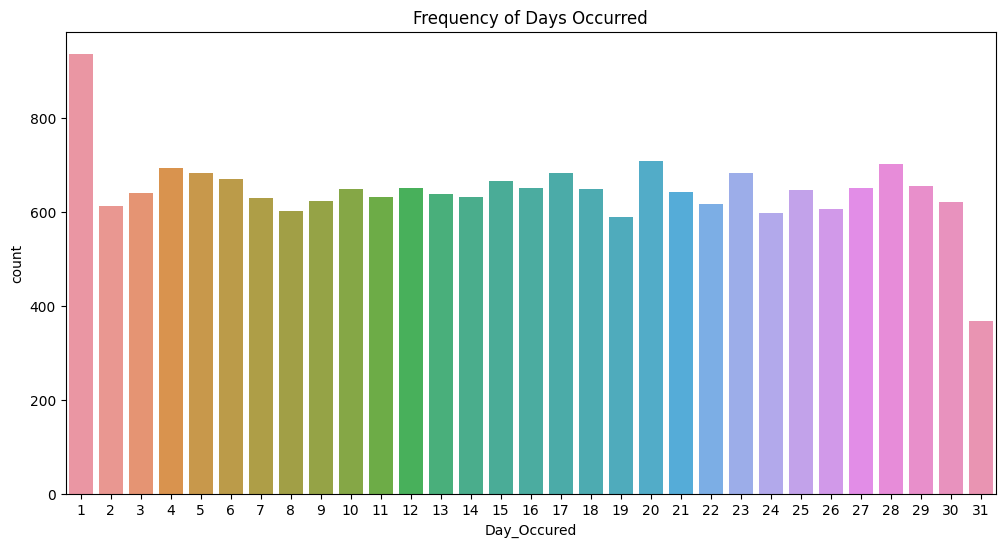

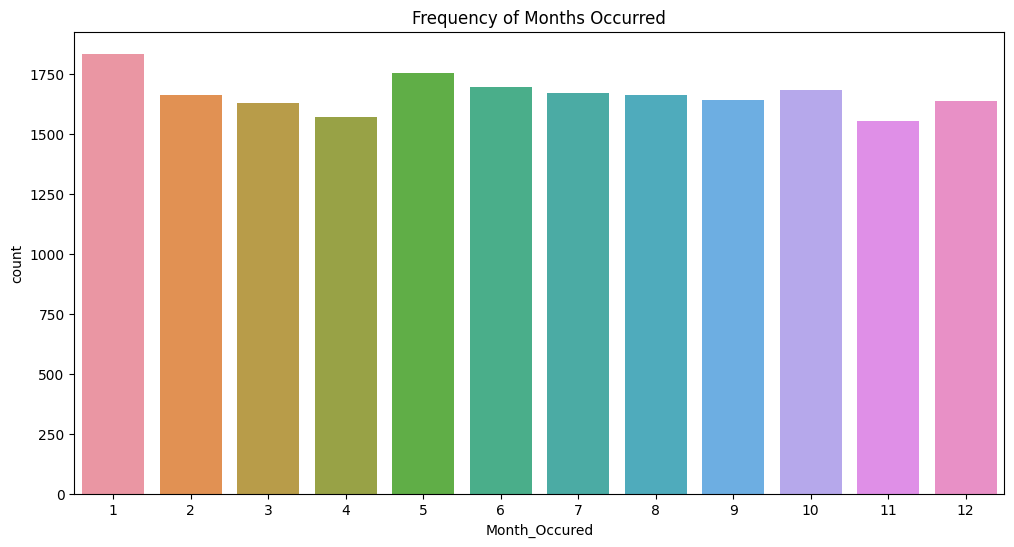

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=new_df, x='Day_Occured')
plt.title('Frequency of Days Occurred')
plt.show()

# Plot frequency of months
plt.figure(figsize=(12, 6))
sns.countplot(data=new_df, x='Month_Occured')
plt.title('Frequency of Months Occurred')
plt.show()




In [22]:
new_df['Modus_Operandi'] = new_df['Modus_Operandi'].fillna('null')
new_test_df['Modus_Operandi'] = new_test_df['Modus_Operandi'].fillna('null')

mod_op_list = new_df['Modus_Operandi'].str.split()
unique_mod_op = set()
for row in mod_op_list:
    unique_mod_op.update(row)
unique_mod_op = sorted(unique_mod_op)  


print("Unique Modus_Operandi codes from training data:", unique_mod_op)

Unique Modus_Operandi codes from training data: ['0100', '0104', '0105', '0110', '0112', '0113', '0114', '0115', '0117', '0120', '0121', '0200', '0201', '0202', '0206', '0207', '0209', '0210', '0211', '0212', '0213', '0216', '0217', '0220', '0301', '0302', '0303', '0304', '0305', '0307', '0308', '0309', '0310', '0311', '0312', '0314', '0315', '0316', '0319', '0321', '0322', '0323', '0324', '0325', '0326', '0327', '0328', '0329', '0330', '0332', '0334', '0335', '0336', '0337', '0338', '0339', '0340', '0341', '0342', '0343', '0344', '0345', '0346', '0347', '0349', '0350', '0351', '0352', '0353', '0354', '0355', '0356', '0357', '0358', '0359', '0360', '0361', '0362', '0363', '0364', '0365', '0366', '0368', '0369', '0370', '0371', '0372', '0373', '0374', '0375', '0377', '0378', '0379', '0380', '0381', '0382', '0383', '0384', '0385', '0386', '0387', '0388', '0389', '0390', '0391', '0392', '0394', '0395', '0396', '0397', '0398', '0399', '0400', '0401', '0402', '0404', '0405', '0406', '0407',

In [23]:
def fe_modus_operandi(df, unique_mod_op):
    mod_op_list = df['Modus_Operandi'].str.split()
    
    mod_op_cols = {f'Modus_{modus}': [] for modus in unique_mod_op}
    
    for row in mod_op_list:
        row_set = set(row)
        for modus in unique_mod_op:
            mod_op_cols[f'Modus_{modus}'].append(1 if modus in row_set else 0)
    
    mod_op_df = pd.DataFrame(mod_op_cols)
    
    df = pd.concat([df, mod_op_df], axis=1)
    
    return df

# Applying feature engineering to train and test datasets
new_df = fe_modus_operandi(new_df, unique_mod_op)
new_test_df = fe_modus_operandi(new_test_df, unique_mod_op)


In [24]:
new_df = new_df.drop(['Modus_Operandi'], axis = 1)
new_test_df = new_test_df.drop(['Modus_Operandi'], axis = 1)

# Data Preprocessing

In [25]:
le=LabelEncoder()
y=new_df['Crime_Category']
y_coded=le.fit_transform(y)
y_coded=pd.DataFrame(y_coded,columns=['Crime_Category']).values.ravel()


In [26]:
new_df = new_df.drop(['Crime_Category'], axis=1)

In [27]:
cat_var_1_cols = ['Victim_Sex', 'Victim_Descent', 'Status']
cat_var_2_cols = ['Part 1-2', 'Area_ID',  'Premise_Code', 'Weapon_Used_Code']
num_var_cols = ['Latitude','Victim_Age', 'Time_Occurred',
               'Day_Occured', 'Month_Occured', 'Day_Reported', 'Month_Reported']


In [28]:
cat_var_1_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [29]:
num_var_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('scaler', StandardScaler())
])

In [30]:
cat_var_2_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_var_1', cat_var_1_transformer, cat_var_1_cols),
        ('num', num_var_transformer, num_var_cols),
        ('cat_var_2',cat_var_2_transformer, cat_var_2_cols)
    ], remainder='passthrough')

In [32]:
X_train_preprocessed = preprocessor.fit_transform(new_df)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
test_preprocessed = preprocessor.transform(new_test_df)
test_preprocessed = pd.DataFrame(test_preprocessed)

In [33]:
X_train_preprocessed.shape

(20000, 815)

In [34]:
print(f"Count of NaN values in 'train_csv': {X_train_preprocessed.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test_preprocessed.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 0 values
Count of NaN values in 'test_csv': 0 values


# Splitting Training Data into Traininig and Validation Set

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train_preprocessed, y_coded, test_size=0.2, stratify=y, random_state=42)

print("Shape of Training set:", X_train.shape, y_train.shape)
print("Shape of Validation set:", X_test.shape, y_test.shape)

Shape of Training set: (16000, 815) (16000,)
Shape of Validation set: (4000, 815) (4000,)


# Building Models

# Model 1 -  Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

#calculating the accuracy of the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

# Detailed classification report
print(classification_report(y_test, y_pred_rf))

y_pred = rf_model.predict(test_preprocessed)


Random Forest Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.86      0.27      0.41        45
           1       0.86      0.81      0.84       362
           2       0.95      0.96      0.95       271
           3       0.33      0.03      0.05        36
           4       0.99      0.98      0.99      2333
           5       0.89      0.98      0.93       953

    accuracy                           0.95      4000
   macro avg       0.81      0.67      0.69      4000
weighted avg       0.95      0.95      0.94      4000



# Model 2 - XGB Classifier

In [37]:
xgb_model = XGBClassifier(        
    random_state=42,
    colsample_bytree=0.7438600453765822,
    learning_rate=0.20546654188465587,
    max_depth=7,
    n_estimators=50,
    subsample=0.9166006316800473,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# params for hyperparameter tuning
# params = {
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'max_depth': [3, 6, 10],
#     'n_estimators': [100, 500, 1000],
#     'subsample': [0.5, 0.7, 1.0]
# }

#using Grid Search for hyperparameter tuning
# gv = GridSearchCV(xgb_model, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# gv.fit(X_train, y_train)
# best_params = gv.best_params_
# print(f'Best parameters found: {best_params}')

y_pred_xgb = xgb_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}')

# Detailed classification report
print(classification_report(y_test, y_pred_xgb))

# predictions on the preprocessed test data
y_pred = xgb_model.predict(test_preprocessed)


XGBoost Accuracy: 0.959
              precision    recall  f1-score   support

           0       0.84      0.58      0.68        45
           1       0.86      0.88      0.87       362
           2       0.94      0.94      0.94       271
           3       0.50      0.22      0.31        36
           4       0.99      0.99      0.99      2333
           5       0.93      0.97      0.95       953

    accuracy                           0.96      4000
   macro avg       0.84      0.76      0.79      4000
weighted avg       0.96      0.96      0.96      4000



# Model 3 - Bagging Classifier

In [38]:
xgb_base = XGBClassifier(n_estimators=100, random_state=42)

# Initializing  the BaggingClassifier with the XGBClassifier as the base estimator
bagging_model = BaggingClassifier(base_estimator=xgb_base, n_estimators=10, random_state=42)

bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)


#calculating the accuracy of the model
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Classifier with XGBoost Accuracy: {accuracy_bagging}')

# Detailed classification report
print(classification_report(y_test, y_pred_bagging))

y_pred = bagging_model.predict(test_preprocessed)


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier with XGBoost Accuracy: 0.95975
              precision    recall  f1-score   support

           0       0.77      0.53      0.63        45
           1       0.85      0.89      0.87       362
           2       0.96      0.95      0.96       271
           3       0.58      0.19      0.29        36
           4       0.99      0.99      0.99      2333
           5       0.93      0.97      0.95       953

    accuracy                           0.96      4000
   macro avg       0.85      0.75      0.78      4000
weighted avg       0.96      0.96      0.96      4000



# Comparing Model Performance

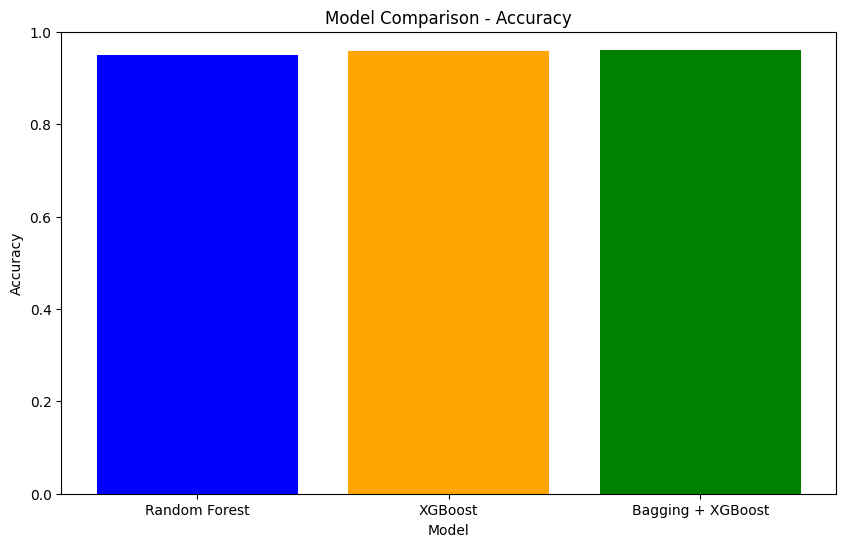

In [39]:
models = ['Random Forest', 'XGBoost', 'Bagging + XGBoost']
accuracies = [accuracy_rf, accuracy_xgb, accuracy_bagging]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.show()

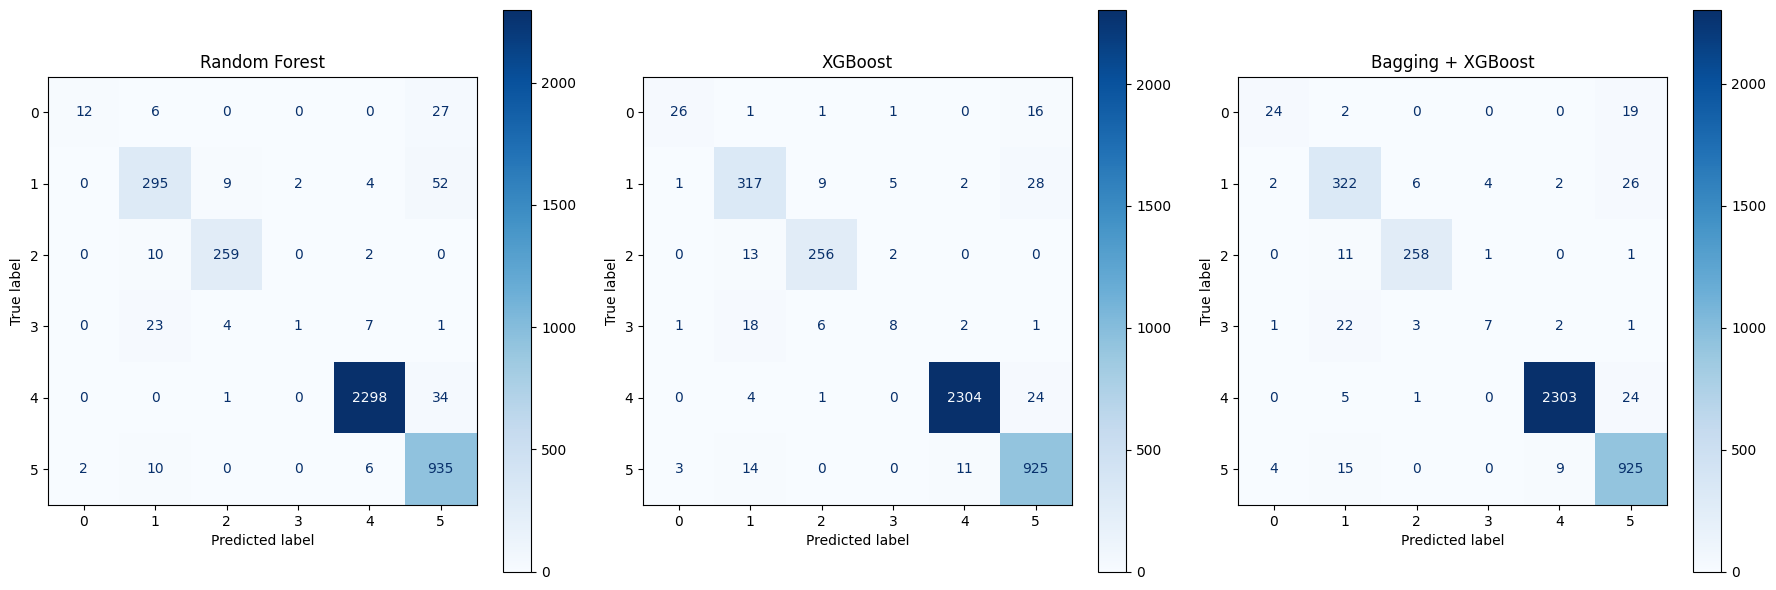

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=ax[0], cmap='Blues')
ax[0].title.set_text('Random Forest')

# Confusion Matrix for XGBoost
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax[1], cmap='Blues')
ax[1].title.set_text('XGBoost')

# Confusion Matrix for Bagging with XGBoost
ConfusionMatrixDisplay.from_estimator(bagging_model, X_test, y_test, ax=ax[2], cmap='Blues')
ax[2].title.set_text('Bagging + XGBoost')

plt.tight_layout()
plt.show()


# Submiting to the Competition

In [41]:
submission = pd.DataFrame(columns=['ID', 'Crime_Category'])
submission['ID'] = [i for i in range(1, len(y_pred) + 1)]
submission['Crime_Category'] = le.inverse_transform(y_pred)
submission.to_csv('/kaggle/working/submission.csv', index=False)